# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

La empresa necesita saber cual de sus dos tarifas de prepago le genera mas ingresos, es mas viable y cual es mejor en ciertas situaciones, imagino que los datos van a indicar que alguna tarifa es mas viable para un grupo de personas y el otro puede ser mas generico.


Tengo planeado explorar los los archivos, estudiarlos y entonces limpiar los datos, procesarlos para poder trabajar con ellos, hacer agrupaciones, combinar tablas por sus indices, e ir fase por fase hasta graficar los datos, entender su distribucion, interpretarlos y despues ahora si empezar a hacer algunas hipotesis para lograr saber cual tarifa le combiene mas a la empresa, conociendo previamente como se comportan los usuarios.

## Inicialización

In [1]:
# Cargar todas las librerías
import numpy as np
import pandas as pd
from scipy import stats as st
import matplotlib.pyplot as plt

## Cargar datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames
df_megaline_calls = pd.read_csv('/datasets/megaline_calls.csv')
df_megaline_internet = pd.read_csv('/datasets/megaline_internet.csv')
df_megaline_messages = pd.read_csv('/datasets/megaline_messages.csv')
df_megaline_plans = pd.read_csv('/datasets/megaline_plans.csv')
df_megaline_users = pd.read_csv('/datasets/megaline_users.csv')


## Preparar los datos

In [3]:
print("Muestra de datos de los usuarios de Megaline: \n\n", df_megaline_users.head())
df_megaline_users.info()
print("\nMuestra de datos de las llamadas de los usuarios: \n\n", df_megaline_calls.head())
df_megaline_calls.info()
print("\nMuestra de datos de los mensajes de los usuarios: \n\n",df_megaline_messages.head())
df_megaline_messages.info()
print("\nMuestra de datos de las sesiones web de los usuarios: \n\n",df_megaline_internet.head())
df_megaline_internet.info()
print("\nMuestra de datos de los planes de Megaline: \n\n",df_megaline_plans.head())
df_megaline_plans.info()


Muestra de datos de los usuarios de Megaline: 

    user_id first_name  last_name  age                                   city  \
0     1000   Anamaria      Bauer   45  Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36   Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo    Jenkins   52                          Tulsa, OK MSA   
4     1004    Leonila   Thompson   40        Seattle-Tacoma-Bellevue, WA MSA   

     reg_date      plan churn_date  
0  2018-12-24  ultimate        NaN  
1  2018-08-13      surf        NaN  
2  2018-10-21      surf        NaN  
3  2018-01-28      surf        NaN  
4  2018-05-23      surf        NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non

A simple vista los datos parecen completos, no hay nulos y el formato parece el adecuado.

Ya comprendo mejor cada tabla y su contenido.

## Tarifas

In [4]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
df_megaline_plans.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [5]:
# Imprime una muestra de los datos para las tarifas
print(df_megaline_plans.head())


   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  



Los tipos de datos me parecen adecuados y no parece haber datos ausentes.
De momento me parece que solo necesito renombrar la columna usd_monthly_pay por usd_monthly_fee para mantener la coherencia

## Corregir datos

In [6]:
# Renombrar columna para mantener coherencia
df_megaline_plans = df_megaline_plans.rename(
    columns={'usd_monthly_pay': 'usd_monthly_fee'}
)

## Enriquecer los datos

In [7]:
# Estandarizar nombres de plan y convertir a categoría
df_megaline_plans['plan_name'] = (
    df_megaline_plans['plan_name']
    .str.capitalize()
    .astype('category')
)

df_megaline_plans['gb_per_month_included'] = (
    df_megaline_plans['mb_per_month_included'] / 1024
)
print(df_megaline_plans.head())

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_fee  usd_per_gb  usd_per_message  usd_per_minute plan_name  \
0               20          10             0.03            0.03      Surf   
1               70           7             0.01            0.01  Ultimate   

   gb_per_month_included  
0                   15.0  
1                   30.0  


Estandarizo el plan como categoría, optimizando memoria y dejando claro que es una variable discreta.

Puede que llegue a necesitar tener los gigabites al mes en GB para alguna grafica.

## Usuarios/as

In [8]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
df_megaline_users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [9]:
# Imprime una muestra de datos para usuarios
print(df_megaline_users.head())


   user_id first_name  last_name  age                                   city  \
0     1000   Anamaria      Bauer   45  Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36   Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo    Jenkins   52                          Tulsa, OK MSA   
4     1004    Leonila   Thompson   40        Seattle-Tacoma-Bellevue, WA MSA   

     reg_date      plan churn_date  
0  2018-12-24  ultimate        NaN  
1  2018-08-13      surf        NaN  
2  2018-10-21      surf        NaN  
3  2018-01-28      surf        NaN  
4  2018-05-23      surf        NaN  


### Corregir los datos

In [10]:
# Convertir fechas a datetime
df_megaline_users['reg_date'] = pd.to_datetime(df_megaline_users['reg_date'])
df_megaline_users['churn_date'] = pd.to_datetime(df_megaline_users['churn_date'])

### Enriquecer los datos

In [11]:
# Convertir 'plan' a categoría
df_megaline_users['plan'] = df_megaline_users['plan'].str.capitalize().astype('category')

# Podria ser util extraer el estado y guardarlo en una columna diferente
df_megaline_users['state'] = (
    df_megaline_users['city']
    .str.extract(r',\s*([A-Z]{2})\s+MSA$')
    .fillna('Unknown')
    .astype('category')
)

print(df_megaline_users.head())

   user_id first_name  last_name  age                                   city  \
0     1000   Anamaria      Bauer   45  Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36   Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo    Jenkins   52                          Tulsa, OK MSA   
4     1004    Leonila   Thompson   40        Seattle-Tacoma-Bellevue, WA MSA   

    reg_date      plan churn_date state  
0 2018-12-24  Ultimate        NaT    GA  
1 2018-08-13      Surf        NaT    WA  
2 2018-10-21      Surf        NaT    NV  
3 2018-01-28      Surf        NaT    OK  
4 2018-05-23      Surf        NaT    WA  


## Llamadas

In [12]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
df_megaline_calls.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [13]:
# Imprime una muestra de datos para las llamadas
print(df_megaline_calls.head())


         id  user_id   call_date  duration
0   1000_93     1000  2018-12-27      8.52
1  1000_145     1000  2018-12-27     13.66
2  1000_247     1000  2018-12-27     14.48
3  1000_309     1000  2018-12-28      5.76
4  1000_380     1000  2018-12-30      4.22


### Corregir los datos

In [14]:
# Convertir 'call_date' a un objeto datetime
df_megaline_calls['call_date'] = pd.to_datetime(
    df_megaline_calls['call_date']
)

### Enriquecer los datos

In [15]:
# Siguiendo el modelo de negocio de Megaline redondeamos la duración al minuto siguiente (ceil)
#    y lo guardamos en una nueva columna
df_megaline_calls['duration_min'] = np.ceil(
    df_megaline_calls['duration']
).astype(int)

print(df_megaline_calls.head())

         id  user_id  call_date  duration  duration_min
0   1000_93     1000 2018-12-27      8.52             9
1  1000_145     1000 2018-12-27     13.66            14
2  1000_247     1000 2018-12-27     14.48            15
3  1000_309     1000 2018-12-28      5.76             6
4  1000_380     1000 2018-12-30      4.22             5


## Mensajes

In [16]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
df_megaline_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [17]:
# Imprime una muestra de datos para los mensajes
print(df_megaline_messages.head())

         id  user_id message_date
0  1000_125     1000   2018-12-27
1  1000_160     1000   2018-12-31
2  1000_223     1000   2018-12-31
3  1000_251     1000   2018-12-27
4  1000_255     1000   2018-12-26


### Corregir los datos

In [18]:
# Cambiamos a datetime para trabajar mas a gusto
df_megaline_messages['message_date'] = pd.to_datetime(
    df_megaline_messages['message_date']
)

### Enriquecer los datos

In [19]:
# dejamos asi de momento

## Internet

In [20]:
# Imprime la información general/resumida sobre el DataFrame de internet
df_megaline_internet.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [21]:
# Imprime una muestra de datos para el tráfico de internet
print(df_megaline_internet.head(10))


         id  user_id session_date  mb_used
0   1000_13     1000   2018-12-29    89.86
1  1000_204     1000   2018-12-31     0.00
2  1000_379     1000   2018-12-28   660.40
3  1000_413     1000   2018-12-26   270.99
4  1000_442     1000   2018-12-27   880.22
5    1001_0     1001   2018-08-24   284.68
6    1001_3     1001   2018-12-09   656.04
7    1001_4     1001   2018-11-04    16.97
8   1001_10     1001   2018-11-27   135.18
9   1001_15     1001   2018-12-13   761.92


### Corregir los datos

In [22]:
# Convertir fecha de sesión a datetime
df_megaline_internet['session_date'] = pd.to_datetime(
    df_megaline_internet['session_date']
)
print(df_megaline_internet.head(10))

         id  user_id session_date  mb_used
0   1000_13     1000   2018-12-29    89.86
1  1000_204     1000   2018-12-31     0.00
2  1000_379     1000   2018-12-28   660.40
3  1000_413     1000   2018-12-26   270.99
4  1000_442     1000   2018-12-27   880.22
5    1001_0     1001   2018-08-24   284.68
6    1001_3     1001   2018-12-09   656.04
7    1001_4     1001   2018-11-04    16.97
8   1001_10     1001   2018-11-27   135.18
9   1001_15     1001   2018-12-13   761.92


### Enriquecer los datos

In [23]:
# Dejamos asi de momento

NOTA: REDONDEO A GIGABYTES

Según la regla de facturación, se redondea el total mensual de datos a gigabytes. Aquí mb_used es por sesión; más adelante, al agrupar por usuario y mes, sumaremos estos mb_used y luego aplicaremos np.ceil(total_mb / 1024) para obtener los gigabytes facturables.

## Estudiar las condiciones de las tarifas

In [24]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
print(df_megaline_plans)

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_fee  usd_per_gb  usd_per_message  usd_per_minute plan_name  \
0               20          10             0.03            0.03      Surf   
1               70           7             0.01            0.01  Ultimate   

   gb_per_month_included  
0                   15.0  
1                   30.0  


In [25]:
# Creamos columna 'month' con el período año-mes
# año-mes se me hizo algo todavia mas realista
df_megaline_calls['month'] = df_megaline_calls['call_date'].dt.to_period('M')

# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
calls_per_user_month = (
    df_megaline_calls
    .groupby(['user_id', 'month'])['id']
    .count()
    .reset_index(name='calls_count')
)
# print(df_megaline_calls.head())
print(calls_per_user_month)

      user_id    month  calls_count
0        1000  2018-12           16
1        1001  2018-08           27
2        1001  2018-09           49
3        1001  2018-10           65
4        1001  2018-11           64
...       ...      ...          ...
2253     1498  2018-12           39
2254     1499  2018-09           41
2255     1499  2018-10           53
2256     1499  2018-11           45
2257     1499  2018-12           65

[2258 rows x 3 columns]


In [26]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
minutes_per_user_month = (
    df_megaline_calls
    .groupby(['user_id', 'month'])['duration_min']
    .sum()
    .reset_index(name='minutes_used')
)

print(minutes_per_user_month.head(10))

   user_id    month  minutes_used
0     1000  2018-12           124
1     1001  2018-08           182
2     1001  2018-09           315
3     1001  2018-10           393
4     1001  2018-11           426
5     1001  2018-12           412
6     1002  2018-10            59
7     1002  2018-11           386
8     1002  2018-12           384
9     1003  2018-12          1104


In [27]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
df_megaline_messages['month'] = df_megaline_messages['message_date'].dt.to_period('M')

messages_per_user_month = (
    df_megaline_messages
    .groupby(['user_id', 'month'])['id']
    .count()
    .reset_index(name='messages_sent')
)

print(messages_per_user_month.head(10))


   user_id    month  messages_sent
0     1000  2018-12             11
1     1001  2018-08             30
2     1001  2018-09             44
3     1001  2018-10             53
4     1001  2018-11             36
5     1001  2018-12             44
6     1002  2018-10             15
7     1002  2018-11             32
8     1002  2018-12             41
9     1003  2018-12             50


In [28]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.

df_megaline_internet['month'] = df_megaline_internet['session_date'].dt.to_period('M')

internet_per_user_month = (
    df_megaline_internet
    .groupby(['user_id', 'month'])['mb_used']
    .sum()
    .reset_index(name='internet_used')
)

# Aqui ya podemos convertir los MB a GB facturables, redondeando hacia arriba
internet_per_user_month['gb_used'] = np.ceil(
    internet_per_user_month['internet_used'] / 1024
).astype(int)

print(internet_per_user_month)

      user_id    month  internet_used  gb_used
0        1000  2018-12        1901.47        2
1        1001  2018-08        6919.15        7
2        1001  2018-09       13314.82       14
3        1001  2018-10       22330.49       22
4        1001  2018-11       18504.30       19
...       ...      ...            ...      ...
2272     1498  2018-12       23137.69       23
2273     1499  2018-09       12984.76       13
2274     1499  2018-10       19492.43       20
2275     1499  2018-11       16813.83       17
2276     1499  2018-12       22059.21       22

[2277 rows x 4 columns]


In [29]:
# Fusionamos los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
user_month = minutes_per_user_month.merge(
    messages_per_user_month,
    on=['user_id', 'month'],
    how='outer' # utilizamos outer para no perder registros, despues rellenaremos los nulos
).merge(
    internet_per_user_month[['user_id', 'month', 'gb_used']],
    on=['user_id', 'month'],
    how='outer'
)

# tenemos algunos valores nulos, usuarios que no hicieron alguna de las 3 cosas
user_month = user_month.fillna(0)
print(user_month)
#user_month.info()

      user_id    month  minutes_used  messages_sent  gb_used
0        1000  2018-12         124.0           11.0      2.0
1        1001  2018-08         182.0           30.0      7.0
2        1001  2018-09         315.0           44.0     14.0
3        1001  2018-10         393.0           53.0     22.0
4        1001  2018-11         426.0           36.0     19.0
...       ...      ...           ...            ...      ...
2288     1349  2018-12           0.0           61.0     13.0
2289     1361  2018-05           0.0            2.0      2.0
2290     1482  2018-10           0.0            2.0      0.0
2291     1108  2018-12           0.0            0.0      1.0
2292     1311  2018-06           0.0            0.0      2.0

[2293 rows x 5 columns]


In [30]:
# Añade la información de la tarifa
user_plans = df_megaline_users[['user_id','plan']]

user_month = user_month.merge(
    user_plans,
    on='user_id',
    how='left'
)

user_month['minutes_used'] = user_month['minutes_used'].astype('int64')
user_month['messages_sent'] = user_month['messages_sent'].astype('int64')
user_month['gb_used'] = user_month['gb_used'].astype('int64')
print(user_month)

      user_id    month  minutes_used  messages_sent  gb_used      plan
0        1000  2018-12           124             11        2  Ultimate
1        1001  2018-08           182             30        7      Surf
2        1001  2018-09           315             44       14      Surf
3        1001  2018-10           393             53       22      Surf
4        1001  2018-11           426             36       19      Surf
...       ...      ...           ...            ...      ...       ...
2288     1349  2018-12             0             61       13      Surf
2289     1361  2018-05             0              2        2      Surf
2290     1482  2018-10             0              2        0  Ultimate
2291     1108  2018-12             0              0        1  Ultimate
2292     1311  2018-06             0              0        2  Ultimate

[2293 rows x 6 columns]


In [31]:
user_month = user_month.merge(
    df_megaline_plans,
    left_on='plan',
    right_on='plan_name',
    how='left'
)

In [32]:
user_month = user_month.drop(columns=[
    'plan_name',
    'mb_per_month_included'
]).reset_index(drop=True)
#user_month.info() # para ver que tenemos los datos de las tarifas
print(user_month)


      user_id    month  minutes_used  messages_sent  gb_used      plan  \
0        1000  2018-12           124             11        2  Ultimate   
1        1001  2018-08           182             30        7      Surf   
2        1001  2018-09           315             44       14      Surf   
3        1001  2018-10           393             53       22      Surf   
4        1001  2018-11           426             36       19      Surf   
...       ...      ...           ...            ...      ...       ...   
2288     1349  2018-12             0             61       13      Surf   
2289     1361  2018-05             0              2        2      Surf   
2290     1482  2018-10             0              2        0  Ultimate   
2291     1108  2018-12             0              0        1  Ultimate   
2292     1311  2018-06             0              0        2  Ultimate   

      messages_included  minutes_included  usd_monthly_fee  usd_per_gb  \
0                  1000              

In [33]:
# Calcular los ingresos mensuales

# 1. Calculamos excedentes (siempre valores >= 0)
user_month['over_calls'] = (user_month['minutes_used'] - user_month['minutes_included']).clip(lower=0)
user_month['over_msgs'] = (user_month['messages_sent'] - user_month['messages_included']).clip(lower=0)
user_month['over_gb'] = (user_month['gb_used'] - user_month['gb_per_month_included']).clip(lower=0)

# 2. Calculamos cargos adicionales
user_month['charge_calls'] = user_month['over_calls'] * user_month['usd_per_minute']
user_month['charge_msgs'] = user_month['over_msgs'] * user_month['usd_per_message']
user_month['charge_data'] = user_month['over_gb'] * user_month['usd_per_gb']

# 3. Finalmente calculamos el ingreso total = tarifa mensual + cargos adicionales
user_month['monthly_revenue'] = (
    user_month['usd_monthly_fee']
  + user_month['charge_calls']
  + user_month['charge_msgs']
  + user_month['charge_data']
)

print(user_month.head(10))

   user_id    month  minutes_used  messages_sent  gb_used      plan  \
0     1000  2018-12           124             11        2  Ultimate   
1     1001  2018-08           182             30        7      Surf   
2     1001  2018-09           315             44       14      Surf   
3     1001  2018-10           393             53       22      Surf   
4     1001  2018-11           426             36       19      Surf   
5     1001  2018-12           412             44       19      Surf   
6     1002  2018-10            59             15        7      Surf   
7     1002  2018-11           386             32       19      Surf   
8     1002  2018-12           384             41       15      Surf   
9     1003  2018-12          1104             50       27      Surf   

   messages_included  minutes_included  usd_monthly_fee  usd_per_gb  \
0               1000              3000               70           7   
1                 50               500               20          10   
2    

Considere util guardar todo lo mas importante en este dataframe, se me hizo practico y un poco mas sencillo trabajar de este modo.

## Estudia el comportamiento de usuario

### Llamadas

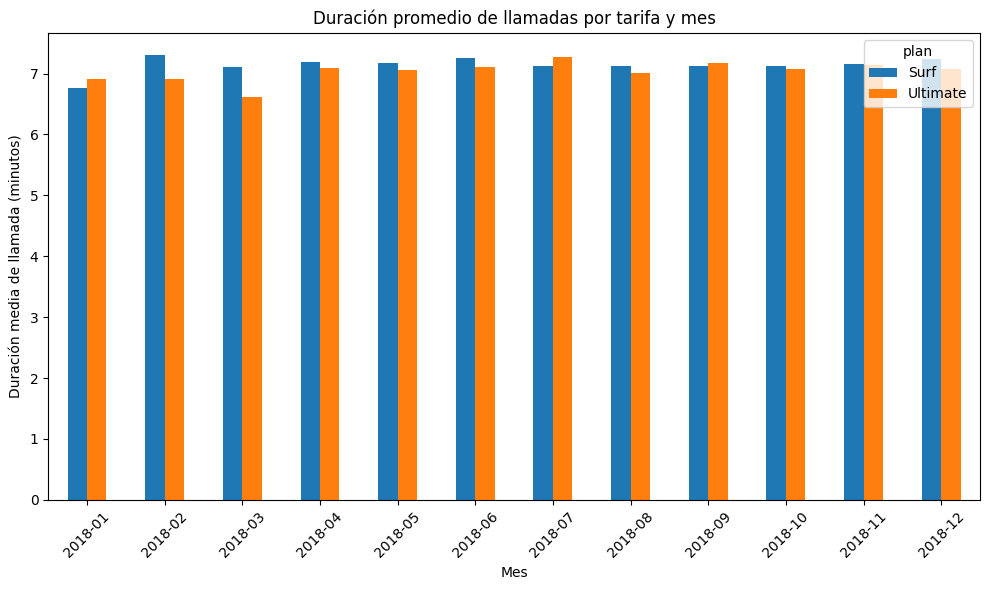

In [34]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
df_calls_with_plan = df_megaline_calls.merge(
    df_megaline_users[['user_id', 'plan']],
    on='user_id',
    how='left'
)
# Calcular duración media por plan y mes
avg_duration = (
    df_calls_with_plan
    .groupby(['plan', 'month'])['duration_min']
    .mean()
    .reset_index(name='avg_duration_min')
)

# Pivot para graficar
pivot = avg_duration.pivot(index='month', columns='plan', values='avg_duration_min')
pivot.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Mes')
plt.ylabel('Duración media de llamada (minutos)')
plt.title('Duración promedio de llamadas por tarifa y mes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [35]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
user_plans = df_megaline_users[['user_id','plan']]

minutes_per_user_month = minutes_per_user_month.merge(
    user_plans,
    on='user_id',
    how='left'
)

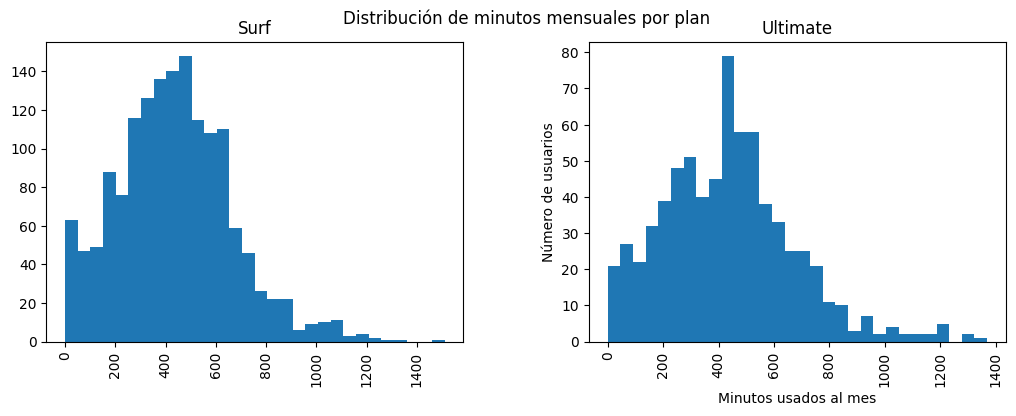

In [36]:
# Graficamos
minutes_per_user_month.hist(
    column='minutes_used',
    by='plan',
    bins=30,
    figsize=(12, 4),
    layout=(1, 2),    # 1 fila, 2 columnas
)

# 2. Ajustes de etiquetas y título global
plt.suptitle('Distribución de minutos mensuales por plan')
plt.xlabel('Minutos usados al mes')
plt.ylabel('Número de usuarios')
plt.show()

In [37]:
# Calcula la media y la varianza de la duración mensual de llamadas.
mean_duration = minutes_per_user_month['minutes_used'].mean()
variance_duration = minutes_per_user_month['minutes_used'].var()
print(f"Media de minutos mensuales: {mean_duration:.2f}")
print(f"Varianza de minutos mensuales: {variance_duration:.2f}")

Media de minutos mensuales: 435.94
Varianza de minutos mensuales: 53811.17


<Figure size 800x600 with 0 Axes>

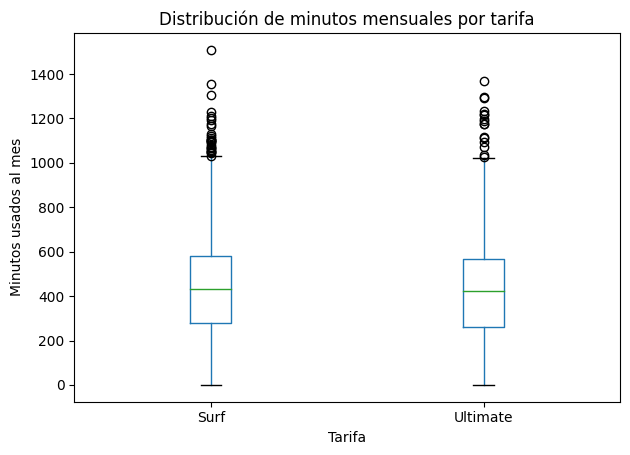

In [38]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
# Boxplot separado por plan
plt.figure(figsize=(8,6))
minutes_per_user_month.boxplot(
    column='minutes_used',
    by='plan',
    grid=False,
    showfliers=True  # muestra outliers
)
plt.title('Distribución de minutos mensuales por tarifa')
plt.suptitle('')  # quita el título automático de pandas
plt.xlabel('Tarifa')
plt.ylabel('Minutos usados al mes')
plt.tight_layout()
plt.show()


Al parecer los usuarios con subscripcion surf parecen ser muy conscientes de los alcances de su paquete y buscan aprovecharlo lo mas que se pueda, mientras que los que tienen subscripcion Ultimate parece que solo compraron la subscripcion porque pudieron y no les importa gastar mucho solo lo que necesitan jaja, es curioso.

Tanto los que tienen la subscripcion ultimate como los de la surf usan casi los mismos mensajes.

### Mensajes

In [39]:
# Compara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
user_plans = df_megaline_users[['user_id','plan']]
messages_per_user_month = messages_per_user_month.merge(
    user_plans,
    on='user_id',
    how='left'
)


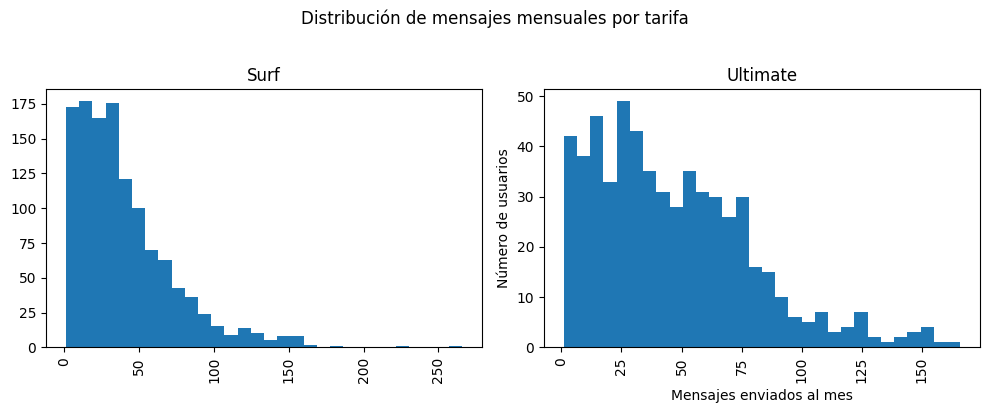

In [40]:
# Histograma por plan (subplots)
messages_per_user_month.hist(
    column='messages_sent',
    by='plan',
    bins=30,
    figsize=(10,4),
    sharex=False,
    sharey=False
)
plt.suptitle('Distribución de mensajes mensuales por tarifa', y=1.02)
plt.xlabel('Mensajes enviados al mes')
plt.ylabel('Número de usuarios')
plt.tight_layout()
plt.show()

In [41]:
# Estadísticos de mensajes por plan
msgs_stats = (
    messages_per_user_month
    .groupby('plan')['messages_sent']
    .agg(['mean','var'])
    .rename(columns={'mean':'mean_messages','var':'var_messages'})
)
print("Estadísticos de mensajes por plan:")
print(msgs_stats)

Estadísticos de mensajes por plan:
          mean_messages  var_messages
plan                                 
Surf          40.109656   1091.344231
Ultimate      46.296233   1085.183108


<Figure size 800x600 with 0 Axes>

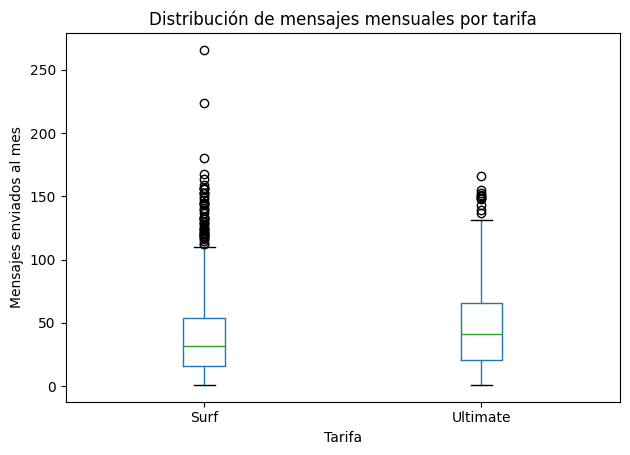

In [42]:
plt.figure(figsize=(8,6))
messages_per_user_month.boxplot(
    column='messages_sent',
    by='plan',
    grid=False,
    showfliers=True
)
plt.title('Distribución de mensajes mensuales por tarifa')
plt.suptitle('')
plt.xlabel('Tarifa')
plt.ylabel('Mensajes enviados al mes')
plt.tight_layout()
plt.show()

1) Mensajes
   
    La gran mayoria de los usuarios con subscripcion ultimate utilizan menos de 150 mensajes de 1000 que pueden enviar, mientras que los usuarios con subscripcion surf aprovechan mejor su paquete y tratan de no rebasar de los 50 la mayoria
    
    En el diagrama de caja se observa como las medias de ambos planes no estan muy distantes ninguno rebasa de los 50 y ambas distribuciones son parecidas.


### Internet

In [43]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan
internet_per_user_month = internet_per_user_month.merge(
    user_plans,
    on='user_id',
    how='left'
)

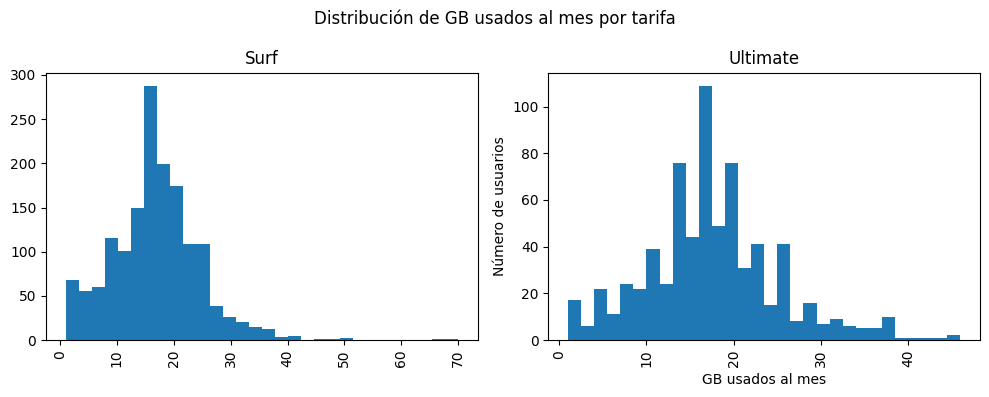

In [44]:
internet_per_user_month.hist(
    column='gb_used',
    by='plan',
    bins=30,
    figsize=(10,4),
    sharex=False,
    sharey=False
)
plt.suptitle('Distribución de GB usados al mes por tarifa')
plt.xlabel('GB usados al mes')
plt.ylabel('Número de usuarios')
plt.tight_layout()
plt.show()

In [45]:
# Estadísticos de GB usados por plan
data_stats = (
    internet_per_user_month
    .groupby('plan')['gb_used']
    .agg(['mean','var'])
    .rename(columns={'mean':'mean_gb','var':'var_gb'})
)
print("\nEstadísticos de GB usados por plan:")
print(data_stats)


Estadísticos de GB usados por plan:
            mean_gb     var_gb
plan                          
Surf      16.831194  59.473734
Ultimate  17.331015  58.494733


<Figure size 800x600 with 0 Axes>

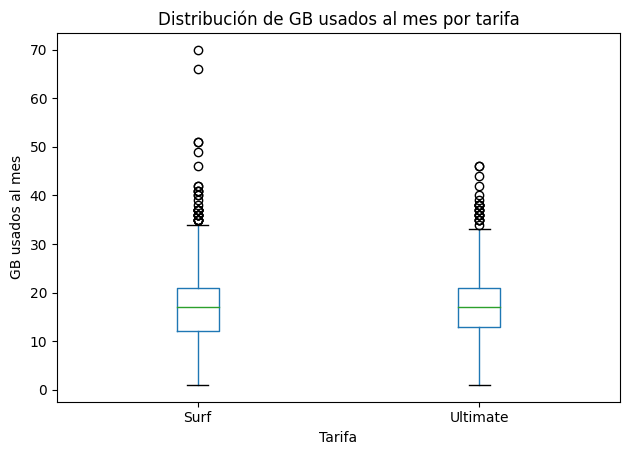

In [46]:
plt.figure(figsize=(8,6))
internet_per_user_month.boxplot(
    column='gb_used',
    by='plan',
    grid=False,
    showfliers=True
)
plt.title('Distribución de GB usados al mes por tarifa')
plt.suptitle('')
plt.xlabel('Tarifa')
plt.ylabel('GB usados al mes')
plt.tight_layout()
plt.show()

[Elabora las conclusiones sobre cómo los usuarios tienden a consumir el tráfico de Internet. ¿Su comportamiento varía en función del plan?]

1) Trafico de Internet

    Las distribuciones tambien son parecidas, la media es muy cercana a 17 en ambos casos y la varianza igual.
    Solo cabe denotar que los usuarios con subscripcion surf tienden a rebasar mas sus limites e incluso tienen mas valores atipicos y debido a que en este plan la tarifa es mas alta por rebasar los limites puede que esto le convenga a Megaline.

## Ingreso

In [47]:
print(user_month)

      user_id    month  minutes_used  messages_sent  gb_used      plan  \
0        1000  2018-12           124             11        2  Ultimate   
1        1001  2018-08           182             30        7      Surf   
2        1001  2018-09           315             44       14      Surf   
3        1001  2018-10           393             53       22      Surf   
4        1001  2018-11           426             36       19      Surf   
...       ...      ...           ...            ...      ...       ...   
2288     1349  2018-12             0             61       13      Surf   
2289     1361  2018-05             0              2        2      Surf   
2290     1482  2018-10             0              2        0  Ultimate   
2291     1108  2018-12             0              0        1  Ultimate   
2292     1311  2018-06             0              0        2  Ultimate   

      messages_included  minutes_included  usd_monthly_fee  usd_per_gb  \
0                  1000              

In [48]:
# Agrupar por plan y calcular media y varianza de monthly_revenue
revenue_stats = (
    user_month
    .groupby('plan')['monthly_revenue']
    .agg(['mean', 'var'])
    .rename(columns={'mean':'mean_revenue', 'var':'var_revenue'})
)

print("Estadísticos de ingreso mensual por tarifa:")
print(revenue_stats)

Estadísticos de ingreso mensual por tarifa:
          mean_revenue  var_revenue
plan                               
Surf         60.706408  3067.835152
Ultimate     72.313889   129.848486


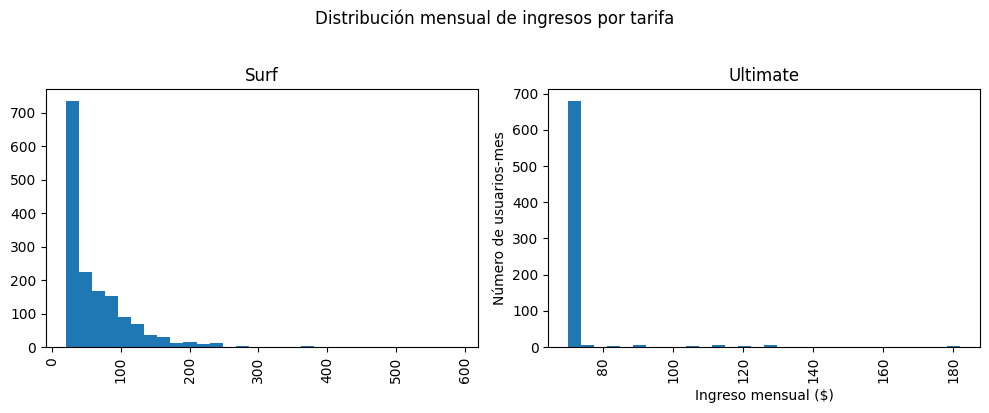

In [49]:
user_month.hist(
    column='monthly_revenue',
    by='plan',
    bins=30,
    figsize=(10,4),
    sharex=False,
    sharey=False
)
plt.suptitle('Distribución mensual de ingresos por tarifa', y=1.02)
plt.xlabel('Ingreso mensual ($)')
plt.ylabel('Número de usuarios-mes')
plt.tight_layout()
plt.show()

Esta grafica al principio se me hizo rara, pero tiene todo el sentido ya que la mayoria de los usuarios no gasta mas de lo que ofrece su plan

Son pocos los usuarios Ultimate que rebasan lo que ofrece su paquete,
hay muchos mas usuarios Surf que rebasan los limites de su paquete 

por ende terminan pagando incluso mas que los usuarios Ultimate
que interesante!!

<Figure size 800x600 with 0 Axes>

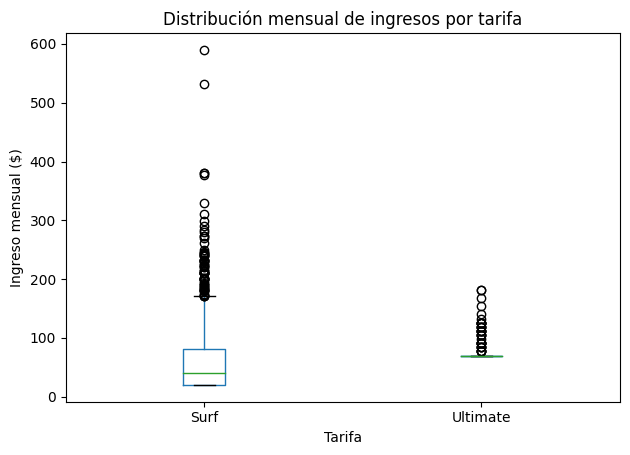

In [50]:
plt.figure(figsize=(8,6))
user_month.boxplot(
    column='monthly_revenue',
    by='plan',
    grid=False,
    showfliers=True
)
plt.title('Distribución mensual de ingresos por tarifa')
plt.suptitle('')
plt.xlabel('Tarifa')
plt.ylabel('Ingreso mensual ($)')
plt.tight_layout()
plt.show()

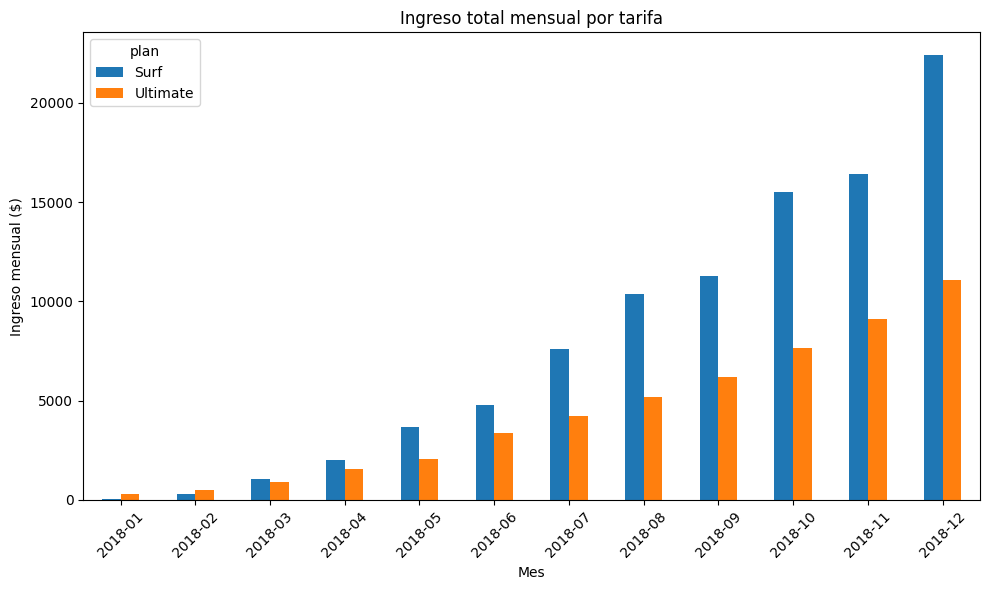

In [51]:
# Calcular ingreso por plan y mes
total_revenue = (
    user_month
    .groupby(['plan','month'])['monthly_revenue']
    .sum()
    .reset_index(name='total_revenue')
)

# Pivot para graficar
pivot_revenue = total_revenue.pivot(index='month', columns='plan', values='total_revenue')

# Gráfico de barras
pivot_revenue.plot(kind='bar', figsize=(10,6))
plt.xlabel('Mes')
plt.ylabel('Ingreso mensual ($)')
plt.title('Ingreso total mensual por tarifa')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [52]:
# Imprimo los datos porque me parecio extraño que crezca cada mes
print(total_revenue)
print(pivot_revenue)

        plan    month  total_revenue
0       Surf  2018-01          40.00
1       Surf  2018-02         309.57
2       Surf  2018-03        1056.65
3       Surf  2018-04        2035.53
4       Surf  2018-05        3667.37
5       Surf  2018-06        4779.80
6       Surf  2018-07        7583.56
7       Surf  2018-08       10356.85
8       Surf  2018-09       11304.67
9       Surf  2018-10       15504.83
10      Surf  2018-11       16415.21
11      Surf  2018-12       22437.14
12  Ultimate  2018-01         280.00
13  Ultimate  2018-02         490.00
14  Ultimate  2018-03         896.00
15  Ultimate  2018-04        1533.00
16  Ultimate  2018-05        2051.00
17  Ultimate  2018-06        3367.00
18  Ultimate  2018-07        4242.00
19  Ultimate  2018-08        5173.00
20  Ultimate  2018-09        6195.00
21  Ultimate  2018-10        7665.00
22  Ultimate  2018-11        9107.00
23  Ultimate  2018-12       11067.00
plan         Surf  Ultimate
month                      
2018-01     40.00  

Wow, cada mes parece crecer la base de usuarios, al principio del año habia pocos cliente con plan Surf, por eso en enero es tan bajo y a medida que pasaron los meses fueron subscribiendose mas usuarios a ambas tarifas.

Puntos importantes:

1) Ultimate genera mas ingreso por usuario, al principio se puede ver claramente como rendia 280 dolares en enero.

2) Pero aqui la ganadora es la subscripcion Surf ya que crecio con mas fuerza al final, podemos ver como en diciembre rinde 22437 dolares mas de el doble que la subscripcion Ultimate con 11067 dolares mensuales.

3) Desde Marzo la subscripcion Surf empezo a generar mas ingresos, esto se puede deber a que normalmente el plan mas barato tiene mas adopcion o bien los usuarios surf exceden sus límites con mas frecuencia y recordemos que en esta tarifa rebasar tus limites sale mas caro.


Recomendaciones

1) Para Surf podria ser viable iniciar campañas que aprovechen esa tendencia y se hagan descuentos a los primeros meses para nuevos subscriptores o que se haga una campaña de invita a un amigo y te regalamos 2 meses gratis, parecido a lo que hacen aqui en TripleTen jaja.
   
3) Ofrecer un cambio a subscripcion Ultimate para los usuarios Surf que rebasan los limites de su paquete con frecuencia.


<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteración)</b> <a class=“tocSkip”></a>

Buen trabajo con la visualizaciones de datos. Además, calculaste correctamente la información estadística de cada distribución de datos, tanto para el consumo de minutos, mensajes e internet, como para los ingresos asociados a los cobros mensuales en cada plan. Esto permite identificar patrones de comportamiento en los usuarios y extraer información valiosa para la compañía.

<div class="alert alert-block alert-warning">
<b>Comentario del revisor (1ra Iteración)</b> <a class=“tocSkip”></a>

Cuando realizas una comparación con histogramas de varias distribuciones es mejor si los superpones, de esta forma la comparación es más directa.

La idea es que se vea algo así:


<img src="https://datavizpyr.com/wp-content/uploads/2020/03/overlapping_histograms_with_matplotlib_Python.png" width="400">

Acá te comparto un enlace donde lo explican [Histogramas](https://datavizpyr.com/overlapping-histograms-with-matplotlib-in-python/)
</div>
</div>

## Prueba las hipótesis estadísticas

[Prueba la hipótesis de que son diferentes los ingresos promedio procedentes de los usuarios de los planes de llamada Ultimate y Surf.]

[Elabora las hipótesis nula y alternativa, escoge la prueba estadística, determina el valor alfa.]

In [53]:
# Prueba las hipótesis
# 1. Extraemos los datos de ingreso mensual por plan
revenues_surf = user_month.loc[user_month['plan'] == 'Surf', 'monthly_revenue']
revenues_ult  = user_month.loc[user_month['plan'] == 'Ultimate', 'monthly_revenue']

#print(revenues_surf)
#print(revenues_ult)
alpha = 0.05
# 2. Aplicamos el t-test de Welch (varianzas desiguales)
results = st.ttest_ind(
    revenues_surf,
    revenues_ult,
    equal_var=False
)

print('valor p:', results.pvalue)

if (results.pvalue  < alpha):
    print("Rechazamos la hipotesis nula")
else:
    print("No podemos rechazar la hipotesis nula")


valor p: 3.1703905481135734e-15
Rechazamos la hipotesis nula


El valor que obtenemos es casi 0 pr lo que rechazamos la hipotesis nula y decimos que existe evidencia estadisticamente suficiente para afirmar que el ingreso medio mensual por usuario-mes no es el mismo en Surf y Ultimate

Si recordamos anteriormente calculamos las media de surf en 60 dolares y Ultimate en 72 dolares por lo que podemos concluir que los usuarios Ultimate aportan en promedio mas ingreso mensual que los de Surf.

In [54]:
#Añadimos la columna city a user_month
user_month_with_city = user_month.merge(
    df_megaline_users[['user_id', 'city']],
    on='user_id',
    how='left'
)

print(user_month_with_city.head(10))


   user_id    month  minutes_used  messages_sent  gb_used      plan  \
0     1000  2018-12           124             11        2  Ultimate   
1     1001  2018-08           182             30        7      Surf   
2     1001  2018-09           315             44       14      Surf   
3     1001  2018-10           393             53       22      Surf   
4     1001  2018-11           426             36       19      Surf   
5     1001  2018-12           412             44       19      Surf   
6     1002  2018-10            59             15        7      Surf   
7     1002  2018-11           386             32       19      Surf   
8     1002  2018-12           384             41       15      Surf   
9     1003  2018-12          1104             50       27      Surf   

   messages_included  minutes_included  usd_monthly_fee  usd_per_gb  ...  \
0               1000              3000               70           7  ...   
1                 50               500               20          1

In [55]:
# Creamos una máscara para usuarios del área “NY-NJ”
mask_nynj = user_month_with_city['city'].str.contains('NY-NJ', regex=False)

# Extraemos los ingresos mensuales de cada grupo
revenues_nynj   = user_month_with_city.loc[mask_nynj,   'monthly_revenue']
revenues_other  = user_month_with_city.loc[~mask_nynj,  'monthly_revenue']

In [56]:
# Prueba las hipótesis
alpha = 0.05

results = st.ttest_ind(
    revenues_nynj,
    revenues_other,
    equal_var=False
)

print("p value: ", results.pvalue)

if results.pvalue < alpha:
    print("Rechazamos la hipotesis nula")
else:
    print("No podemos rechazar la hipotesis nula")

p value:  0.0335256158853001
Rechazamos la hipotesis nula


Rechazamos la hipotesis nula, esto quiere decir que los ingresos promedio difieren entre la ciudad de NY-NJ y otras ciudades.

## Conclusión general

### Desarrollo

Desde el principio del proyecto verificamos y corregimos tipos de datos en su mayoria fue convertir a tipo datetime, fuimos creando nuevas columnas con datos que siguieran las reglas de facturacion como con gb_used para representar los gb facturables.

Agregamos datos a un dataframe por usuario y por periodo año-mes
añadimos llamadas, mensajes e internet, todo lo que consume el usuario en un solo dataframe.

Despues calculamos los ingresos mensuales definiendo los "excedentes" como: 
over_calls = max(minutes_used − minutes_included, 0)
over_msgs = max(messages_sent − messages_included, 0)
over_gb = max(gb_used − gb_per_month_included, 0)
y despues multiplicamos cada excedente por su precio correspondiente (usd_per_minute, usd_per_message, usd_per_gb) y sumamos la tarifa mensual fija (usd_monthly_fee).


### ANALISIS DE USO Y CONSUMO
La duracion de llamadas por usuario vario segun la tarifa seindo que en algunos meses los usuarios de Ultimate hacian llamadas ligeramente mas largas, mientras que los de surf crecian en numero a medida que se unieron nuevos clientes.

Los histogramas y boxplots mostraron que Ultimate tiende a enviar mas SMS al mes (media mayor y menor varianza), mientras que Surf presentaba mayor heterogeneidad en el volumen de mensajes.

Internet
El consumo promedio en GB por mes fue sensiblemente mas alto en Ultimate que en Surf y descubrimos que las distribuciones eran parecidas, la media es muy cercana a 17 en ambos casos y la varianza igual.
Descubrimos que los usuarios con subscripcion surf tienden a rebasar mas sus limites e incluso tienen mas valores atipicos y debido a que en este plan la tarifa es mas alta por rebasar los limites puede que esto le convenga a la empresa.

Ingresos totales y comparaciones por plan
La suma anual de ingresos mostró claramente que, en conjunto, Surf generó más dinero que Ultimate durante 2018.

La media de ingreso mensual por usuario-mes fue mayor en Ultimate que en Surf, pero la base de usuarios de <b>Surf creció con más fuerza</b> (explicando el ingreso total mayor)

### Pruebas de Hipotesis
Nuestra hipotesis fue que los Ingresos promedio de la subscripcion Surf y Ultimate eran iguales con varianzas diferentes asi que aplicamos una t-test.
Rechazamos la hipotesis nula y concluimos que las medias difieren y que <b>Ultimate genera un ingreso promedio mayor</b>.

En la segunda hipotesis dijimos que en promedio la region NY-NJ era igual que la de las otras regiones
Obtuvimos un p-value ≈ 0.0335 < 0.05 por lo que rechazamos la hipotesis nula y concluimos que <b>los usuarios de NY-NJ aportan un ingreso promedio mensual distinto</b>.

Decisiones y supuestos clave
Aplicamos las reglas de negocio (cada llamada cuenta como 1 minuto, total de datos del mes redondeado a GB). Sin estas transformaciones, los cálculos de ingresos habrían sido erróneos.

### Recomendaciones Finales
1) Enfocar marketing en Surf, el plan de menor cuota fija pero que crece rapidamente y aporta, en su conjunto, mas ingresos (se pueden ofrecer meses gratis por invitar a un amigo, bonos extra por permanecer mas de 3 meses o primer mes gratis, entre muchos otros).
   
3) Fomentar "upgrade" a Ultimate para usuarios Surf que rebasan los limites de su paquete con frecuencia.

   
5) Estrategias regionales, dado que NY-NJ difiere en ingreso promedio, tal vez sea conveniente personalizar campañas por region con descuentos geolocalizados o promocion en tiendas de consumo o comercios locales, esto puede mejorar el consumo en cada region.
